# Assignment 1

**Content-Based Image Retrieval**


Similar Image Retrieval (aka Content-Based Image Retrieval or CBIR) is any search that involves images.
Nowadays the "Search by photo" approach is being used more and more actively, in particular, in e-commerce services (AliExpress, Wildberries, etc.). "Keyword search" (with an understanding of the content of images) has long settled in the search engines Google, Yandex, etc.,

**How does it work ?**


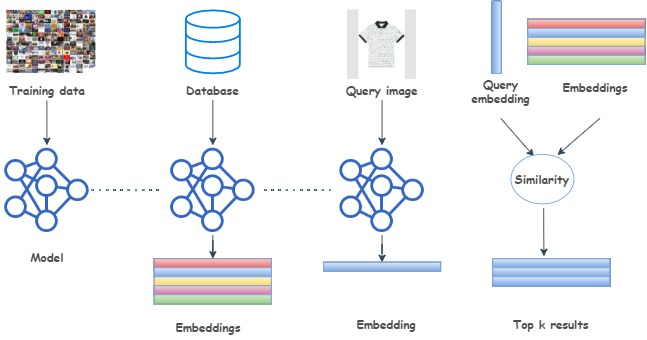


As you can see the pipeline seems easy. First we need a dataset, in this assignment we will be using a large scale benchmark dataset called the Inshop dataset (use the one provided in the link ;) ). The dataset contains training set and testing set. The testing set is divided into two parts query images and gallery images. The query set basically contains images that we will be searching for in the gallery set.


 
**Steps:**
1. Download the dataset 
2. Read the dataset and put it in an appropriate format 
3. Choose a model (you can use pretrained ;) ) and train it
4. Wisely choose a loss function in deep metric learning there are many such as : Contrastive loss, Triplet loss, multi similarity loss, XBM .... Implement one of them. 
5. Measure the scores using the recall metric
6. Report results ( recall values , loss) using tensorboard or Comet or any tool you are comfortable with.  


**Bonus tasks**



1.   Use of hard negative miner (15 points)
2.   Use of PytorchLightening (10 points)




In [30]:
import os
import torch
import time
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.folder import default_loader, IMG_EXTENSIONS
import pytorch_lightning as pl
from pipeline.clothes import TrainDatasetFolder
from pytorch_metric_learning.losses.soft_triple_loss import SoftTripleLoss
from pytorch_metric_learning.miners import TripletMarginMiner
from pytorch_metric_learning.distances import CosineSimilarity
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS

## Preprocessing

In [31]:
# !git clone https://github.com/AlberetOZ/WondeRobe_Clothes_test.git

# !mv WondeRobe_Clothes_test/predictors/ .
# !mv WondeRobe_Clothes_test/yolo/ .

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

yolo_params = {"model_def" : "yolo/df2cfg/yolov3-df2.cfg",
"weights_path" : "yolo/weights/yolov3-df2_15000.weights",
"class_path":"yolo/df2cfg/df2.names",
"conf_thres" : 0.5,
"nms_thres" :0.4,
"img_size" : 416,
"device" : device}

# detector = ClothesDetectorYOLOv3(yolo_params)

## Read data

In [48]:
### PUT YOU CODE HERE ###

"""
Tips : 
    1- For better performance use CenterCrop of size (200,200)
    2- To optimize your code use torchvision.datasets.ImageFolder the dataset provided is already structured 
    3- You can use subset of the dataloader torch.utils.data.Subset in the beggining to test your code then the whole dataset
""" 

class ClothesDataModule(pl.LightningDataModule):

    def __init__(self, data_dir:str = "Inshop-data/"):
        '''
        
        :param data_dir:
        '''
        super().__init__()
        self.data_dir = data_dir
        # self.transforms = transforms.Compose([CropClothes(detector.process), transforms.ToTensor(), transforms.Resize(size=(150, 150))])
        self.transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(150, 150))])
    
    def prepare_data(self):
        # Put dataset download here
        train_data_dir = f'Inshop-data/train_data/'
        self.inshop_full = TrainDatasetFolder(train_data_dir, loader=default_loader, extensions=IMG_EXTENSIONS, transform=self.transforms)
        self.num_of_classes = len(self.inshop_full.classes)
    
    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:

            train_idx, val_idx = train_test_split(list(range(len(self.inshop_full))), test_size=0.1)

            self.inshop_train = Subset(self.inshop_full, train_idx)
            self.inshop_val = Subset(self.inshop_full, val_idx)
            

        # Assign test dataset for use in dataloader(s)
        # if stage == "test" or stage is None:
        #     self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transforms)

            # Optionally...
            # self.dims = tuple(self.mnist_test[0][0].shape)

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self.inshop_train, num_workers=8, batch_size=128)
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self.inshop_val, batch_size=32)


In [49]:
datam = ClothesDataModule()
datam.prepare_data()

Epoch 0:   0%|          | 0/728 [01:47<21:43:09, 107.40s/it]


## Model & loss function

In [50]:
def ResNet50ImgEncoderConv(embeddings_size):
    resnet50 = torchvision.models.resnet50(pretrained=True)
    resnet50.fc = nn.Sequential(
        nn.Linear(2048, 1500),
        nn.Dropout(0.2),
        nn.Linear(1500, 800),
        nn.Dropout(0.2),
        nn.Linear(800, embeddings_size)
    )
    return resnet50
    # return nn.Sequential(
    #     nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=1),
    #     nn.MaxPool2d(kernel_size=2, stride=2),
    #     nn.Conv2d(6, 8, kernel_size=5, stride=1, padding=1),
    #     nn.MaxPool2d(kernel_size=2, stride=2),
    #     nn.Conv2d(8, 10, kernel_size=5, stride=1, padding=1),
    #     nn.MaxPool2d(kernel_size=2, stride=2))

# def SimpleClothesImgEncoderLinear():
#     return nn.Sequential(
#         nn.Linear(17 * 17 * 10, 1500), 
#         nn.Linear(1500, 800),
#         nn.Linear(800, embeddings_size))

def SimpleSoftmax(input_size, num_classes):
    return nn.Sequential(
        nn.Linear(input_size, num_classes),
        nn.Softmax(1)
    )

class ImgModel(pl.LightningModule):

    def __init__(self, loss, mining_funct, num_classes, embeddings_size):
        super().__init__()

        self.conv = ResNet50ImgEncoderConv(embeddings_size)
        # self.linear = SimpleClothesImgEncoderLinear(embeddings_size)
        self.decoder = SimpleSoftmax(embeddings_size, num_classes)
        self.loss = loss
        self.mining_funct = mining_funct
    
    def forward(self, sample):

        x = self.conv(sample)
        x = x.view(x.size(0), -1)
        embeddings = self.linear(x)

        return embeddings
    
    def training_step(self, batch, batch_idx):
        
        x, y = batch

        conv_features = self.conv(x)
        embeddings = conv_features.view(conv_features.size(0), -1)

        classes = self.decoder(embeddings)

        classes = torch.argmax(classes, dim=1)

        indices = self.mining_funct(embeddings, y)

        loss = self.loss.compute_loss(embeddings, classes, indices)
        # self.loss_optimizer.step()
        
        loss = torch.sum(loss['loss']['losses'])

        self.log("train_loss", loss)
        
        return loss
    
    def on_epoch_end(self) -> None:
        self.loss_optimizer.step()
        return super().on_epoch_end()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.1)
        lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1)

        self.loss_optimizer = torch.optim.SGD(self.loss.parameters(), lr=0.01)

        return [optimizer], [lr_scheduler]

In [51]:
loss = SoftTripleLoss(num_classes=datam.num_of_classes, embedding_size=300).to(device)
mining_func = TripletMarginMiner(margin = 0.2, distance = CosineSimilarity(), type_of_triplets = "semihard")

## Train Test

In [52]:
### PUT YOU CODE HERE ###

def train():
    model = ImgModel(loss=loss, mining_funct=mining_func, num_classes=datam.num_of_classes, embeddings_size=300)
    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(model, datamodule=datam)
    
    return ""

def test():
    """ Implement your testing function """
    return ""


train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name         | Type               | Params
----------------------------------------------------
0 | conv         | ResNet             | 28.0 M
1 | decoder      | Sequential         | 5.1 K 
2 | loss         | SoftTripleLoss     | 51.0 K
3 | mining_funct | TripletMarginMiner | 0     
----------------------------------------------------
28.1 M    Trainable params
0         Non-trainable params
28.1 M    Total params
112.315   Total estimated model params size (MB)


Epoch 0:   2%|▏         | 3/182 [01:19<59:02, 19.79s/it, loss=225, v_num=101]

''

### Recall metric

In [ ]:
class RecallMetric(object):
    def __init__(self, feats, labels):

        """
         This function calculates the recall metric 

         feats = [gallery_embeddings, query_embeddings]
         labels = [gallery_labels, query_labels]
        """
        self.is_equal_query = False
        self.gallery_feats, self.query_feats = feats
        self.gallery_labels, self.query_labels = labels
        self.sim_mat = np.matmul(self.query_feats, np.transpose(self.gallery_feats))

    def recall_at_k(self, k=1):
        m = len(self.sim_mat)
        match_counter = 0
        for i in range(m):
            pos_sim = self.sim_mat[i][self.gallery_labels == self.query_labels[i]]
            neg_sim = self.sim_mat[i][self.gallery_labels != self.query_labels[i]]
            thresh = np.sort(pos_sim)[-2] if self.is_equal_query else np.max(pos_sim)
            if np.sum(neg_sim > thresh) < k:
                match_counter += 1
        return float(match_counter) / m

In [ ]:
for epoch in range(1, params["epochs"] + 1):
    
    ### PUT YOUR CODE HERE ### 

    print("Recall@1 : {:.4f} Recall@5 : {:.4f} Recall@10 : {:.4f}".format(recall_at_1,recall_at_5,recall_at_10))



## visualization 


Use a retrieval technique like KNN, annoy, KD-tree (you are free to choose). 

Plot 3 query images with their respective top 5 results 



In [ ]:
    ### PUT YOUR CODE HERE ### 


**Important notes **

1. Deadline is ** 7th september at 10 AM**
2. Cheating is prohibited 

In [ ]:
!git clone https://github.com/AlberetOZ/WondeRobe_Clothes_test.git

Cloning into 'WondeRobe_Clothes_test'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 97 (delta 24), reused 55 (delta 6), pack-reused 0
Unpacking objects: 100% (97/97), done.


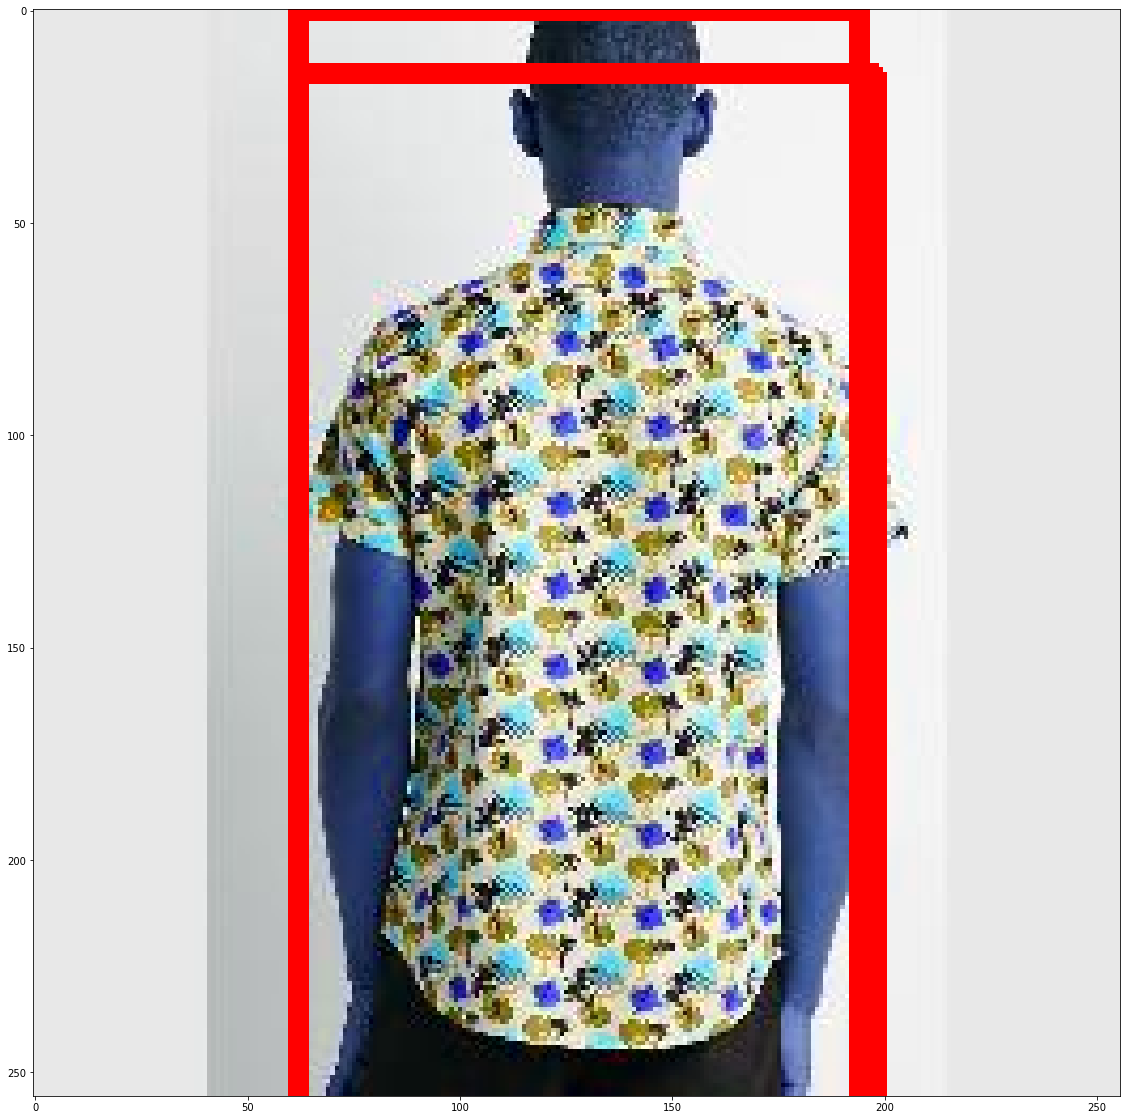

In [ ]:
import cv2
import matplotlib.pyplot as plt
im = cv2.imread('Inshop-data//train_data/1855/img_MEN_Shirts_Polos_id_00003725_03_3_back.jpg')

detections = detector.process(im)

for x1, y1, x2, y2, cls_conf, cls_pred in detections:
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    cv2.rectangle(im,(x1,y1) , (x2,y2) , (255, 0, 0), 3)
    font = cv2.FONT_HERSHEY_SIMPLEX   
    cv2.putText(im,str(cls_pred),(x1,y1-20), font, 0.5,(255,100,255),1,cv2.LINE_AA)

plt.figure(figsize=(20, 20))
plt.imshow(im)
plt.show()

In [ ]:

a = np.array([[1, 2, 3, 1, -1, -1],
              [1, -1, 4, 1, 0, -1],
              [-1, 4, 5, 1, 1, -1]])

In [ ]:
a[np.where(a[:, 0:2] < 0)] = 0

array([[ 1,  2,  3,  1, -1, -1],
       [ 1,  0,  4,  1,  0, -1],
       [ 0,  4,  5,  1,  1, -1]])

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
distances = np.linalg.norm(a[:, 0:2]-center, axis=1)

a[np.argmin(distances)]

array([1, 4, 5, 1])

In [ ]:
from pytorch_metric_learning.utils import loss_and_miner_utils as lmu



ValueError: too many values to unpack (expected 4)

In [38]:
resnet50 = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/maximevgrafov/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 15.9MB/s]


In [39]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 